In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE

# sklearn.set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
flight_data_train = pd.read_csv('./flight_data_train_ts.csv')
flight_data_test = pd.read_csv('./flight_data_test_ts.csv')

In [3]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

flight_data_train.sort_values(by='scheduledoffblocktime', inplace=True)
flight_data_test.sort_values(by='scheduledoffblocktime', inplace=True)

In [4]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [5]:
X_train = flight_data_train.drop(columns=['delay_in_secs'], axis=1)
X_test = flight_data_test.drop(columns=['delay_in_secs'], axis=1)

y_train = flight_data_train['delay_in_secs']
y_test = flight_data_test['delay_in_secs']

In [6]:
X_train

,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyc1,skyc2,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute
0,PS,RA,KTM,332,0,F8,2,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,265
1,PS,ET,ADD,77W,0,D6,1,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,265
2,PS,6E,BOM,320,0,D7,1,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,270
3,PS,EK,MLE,77W,0,C14,3,68.0,60.8,77.75,110.0,6.0,0.0,29.88,5.59,0,NSC,CAVOK,0.0,0.0,8,3,6,275
4,PS,EK,CGK,77W,0,A8,3,68.0,60.8,77.75,110.0,6.0,0.0,29.88,5.59,0,NSC,CAVOK,0.0,0.0,8,3,6,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171716,PS,EK,IST,77W,0,B10,3,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171715,PS,EK,BRU,77W,0,B29,3,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171717,PS,EK,DUS,388,0,B17,3,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171718,PS,EK,LIS,77W,0,B22,3,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,865


In [7]:
# from imblearn.over_sampling import SMOTENC

# smote = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3, 5, 16, 17])
# print('Original dataset shape %s' % Counter(y_train_cls))
# X_train, y_train_cls = smote.fit_resample(X_train, y_train_cls)
# print('Resampled dataset shape %s' % Counter(y_train_cls))


In [8]:
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['airlinecode_iata', 
                         'destination_iata', 
                         'aircraft_iata', 
                         'publicgatenumber',]

catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

X_train_encoded = catboost_encoder.fit_transform(X_train, y_train)

X_test_encoded = catboost_encoder.transform(X_test)

X_train = X_train_encoded
X_test = X_test_encoded

In [9]:
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal']

ohe = OneHotEncoder(drop='first', sparse_output=False)

encoded = ohe.fit_transform(X_train[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



In [10]:
X_train

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3
0,852.965706,852.965706,852.965706,0,852.965706,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,0,0.0,0.0,8,3,6,265,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,852.965706,852.965706,852.965706,0,852.965706,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,0,0.0,0.0,8,3,6,265,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,852.965706,852.965706,852.965706,0,852.965706,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,0,0.0,0.0,8,3,6,270,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,852.965706,852.965706,799.482853,0,852.965706,68.0,60.8,77.75,110.0,6.0,0.0,29.88,5.59,0,0.0,0.0,8,3,6,275,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,426.482853,852.965706,532.988569,0,852.965706,68.0,60.8,77.75,110.0,6.0,0.0,29.88,5.59,0,0.0,0.0,8,3,6,275,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171716,619.078798,667.747416,594.074163,0,494.947951,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,0.0,0.0,6,5,4,860,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
171715,619.077152,483.704076,594.072602,0,596.575985,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,0.0,0.0,6,5,4,860,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
171717,619.091032,534.660685,879.874501,0,713.291934,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,0.0,0.0,6,5,4,860,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
171718,619.084519,672.484574,594.089845,0,520.819542,95.0,66.2,39.00,350.0,12.0,0.0,29.71,4.35,0,0.0,0.0,6,5,4,865,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [11]:
numerical_cols = list(set(X_test.columns) - set(['depart_day', 'depart_month', 'depart_dayofweek', 'depart_minute']))

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [13]:
# Create cyclic features for month and day
X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# Drop original features
X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


In [14]:
X_train.describe()

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,depart_month_sin,depart_month_cos,depart_day_sin,depart_day_cos,depart_dayofweek_sin,depart_dayofweek_cos,depart_minute_sin,depart_minute_cos
count,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.0,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,1.717200e+05,1.717200e+05,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000,171720.000000
mean,0.052304,0.080850,0.060056,0.038219,0.103533,0.462984,0.628277,0.488496,0.564679,0.245467,0.0,0.595309,0.935276,0.004414,0.057889,0.001186,0.712212,0.073987,0.167826,0.000087,0.030625,0.002318,0.998515,0.001205,0.000076,0.000134,0.036024,0.930503,0.187648,0.263493,0.547909,1.289336e-01,1.622953e-01,0.017237,-0.022374,-0.031271,-0.022132,0.097190,-0.104341
std,0.034403,0.044352,0.022813,0.191726,0.044924,0.193086,0.152289,0.186226,0.269624,0.131946,0.0,0.212523,0.155499,0.066293,0.167216,0.032233,0.452733,0.261750,0.373712,0.009346,0.172301,0.048087,0.038507,0.034699,0.008701,0.011572,0.186350,0.254298,0.390432,0.440529,0.497701,7.206386e-01,6.616056e-01,0.710155,0.703483,0.709325,0.703844,0.690874,0.708778
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-0.974928,-0.900969,-1.000000,-1.000000
25%,0.035030,0.050229,0.041992,0.000000,0.067790,0.303030,0.525000,0.361208,0.333333,0.148148,0.0,0.442105,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-5.000000e-01,-5.000000e-01,-0.724793,-0.758758,-0.781831,-0.900969,-0.591310,-0.779884
50%,0.039249,0.072921,0.056056,0.000000,0.103537,0.454545,0.625000,0.494898,0.555556,0.222222,0.0,0.621053,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.224647e-16,6.123234e-17,0.101168,-0.050649,0.000000,-0.222521,0.300706,-0.321439
75%,0.053285,0.099985,0.074378,0.000000,0.122752,0.606061,0.725000,0.626381,0.805556,0.333333,0.0,0.778947,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.660254e-01,8.660254e-01,0.724793,0.688967,0.781831,0.623490,0.751840,0.675590
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.998717,1.000000,0.974928,1.000000,1.000000,1.000000


In [15]:
# neighbors = NearestNeighbors(n_neighbors=39*2)
# neighbors_fit = neighbors.fit(X_train)
# distances, indices = neighbors_fit.kneighbors(X_train)
# avg_distance = distances.mean(axis=1)
# plt.plot(np.sort(avg_distance))
# plt.show()

In [16]:
# sc = DBSCAN(eps=1, min_samples=39*2, algorithm='kd_tree')
# clusters = pd.DataFrame(sc.fit_predict(X_full), columns=['Cluster'])
# clusters['Cluster'].value_counts()

In [17]:
hdbscan_model = HDBSCAN(
    min_cluster_size=2000,      # Increase to avoid microclusters
    min_samples=5,              # Lower to reduce noise points
    cluster_selection_epsilon=0.6,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()

Cluster
 8     62171
 10    26308
 6     21399
 4     16205
-1     15443
 5      8272
 3      5466
 2      3812
 9      3781
 0      3117
 1      2937
 7      2809
Name: count, dtype: int64

In [18]:
from hdbscan import approximate_predict
clusters_test, _ = approximate_predict(hdbscan_model, X_test)

In [19]:
X_train['cluster'] = clusters_train['Cluster']
X_test['cluster'] = clusters_test

In [52]:
from sklearn.ensemble import RandomForestRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK
from hyperopt.mongoexp import MongoTrials

rf_models = {}
metrics = {}
all_y_true = []
all_y_pred = []
model_weights = {}

for cluster in np.unique(clusters_train):
    if cluster == -1:  # Ignore noise points (label -1)
        continue
    
    print(f'Cluster {cluster}')

    # Subset the training and test data for the cluster
    # Get cluster data
    X_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_cluster = y_train.loc[X_cluster.index]
    
    # Split into train and validation sets
    X_train_cluster, X_val_cluster, y_train_cluster, y_val_cluster = train_test_split(
        X_cluster, y_cluster, test_size=0.2, random_state=42
    )
    
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cluster = y_test.loc[X_test_cluster.index]

    # Define hyperparameter search space
    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
        'max_depth': hp.quniform('max_depth', 5, 50, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
        'max_features': hp.choice('max_features', ['sqrt', 'log2']),
        'criterion': hp.choice('criterion', ['squared_error', 'poisson', 'friedman_mse', 'absolute_error'])
    }

    # Define objective function
    def objective(params):
        # Convert float parameters to int
        n_estimators = int(params['n_estimators'])
        max_depth = int(params['max_depth'])
        min_samples_split = int(params['min_samples_split'])
        min_samples_leaf = int(params['min_samples_leaf'])
        max_features = params['max_features']
        criterion = params['criterion']
        
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth, 
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            criterion=criterion
        )
        
        # Use cross validation
        cv_scores = cross_val_score(rf, X_train_cluster, y_train_cluster, 
                                  cv=3, scoring='neg_mean_squared_error')
        
        loss = float(-cv_scores.mean())
        
        return {'loss': loss, 'status': STATUS_OK}

    # Set up MongoDB trials
    trials = MongoTrials('mongo://localhost:1234/hyperopt3/jobs', exp_key=f'hdbscan2_rf_cluster_{cluster}')
    
    # Run optimization
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials,
                rstate=np.random.default_rng(42),
                show_progressbar=True,)
    
    # Get best parameters and convert float to int where needed
    best_params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'min_samples_split': int(best['min_samples_split']),
        'min_samples_leaf': int(best['min_samples_leaf']),
        'max_features': ['sqrt', 'log2'][best['max_features']],
        'criterion': ['squared_error', 'poisson', 'friedman_mse', 'absolute_error'][best['criterion']]
    }

    # Train final model with best parameters
    best_rf = RandomForestRegressor(**best_params)
    best_rf.fit(X_train_cluster, y_train_cluster)
    rf_models[cluster] = best_rf

    # Make predictions on the validation set and evaluate metrics
    y_val_pred = best_rf.predict(X_val_cluster)
    mse = mean_squared_error(y_val_cluster, y_val_pred)
    mae = mean_absolute_error(y_val_cluster, y_val_pred)
    r2 = r2_score(y_val_cluster, y_val_pred)
    model_weights[cluster] = 1 / mse if mse != 0 else 1  # Assign weight to the model based on validation MSE

    # Print metrics
    print(f"Cluster {cluster} Validation Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print("==========================================")
    print()

over-writing old domain trials attachment


Cluster 0
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


InvalidDocument: cannot encode object: 4, of type: <class 'numpy.int64'>

In [21]:
# Normalizing weights to sum to 1
total_weight = sum(model_weights.values())
model_weights = {cluster: weight / total_weight for cluster, weight in model_weights.items()}
model_weights


{0: 0.06554979670045465,
 1: 0.039178910542314316,
 2: 0.0463021828962022,
 3: 0.07393114305136109,
 4: 0.14061718784446348,
 5: 0.11531129236369925,
 6: 0.0502282462612741,
 7: 0.274761232167301,
 8: 0.10350676292045373,
 9: 0.026000195166443883,
 10: 0.0646130500860324}

In [22]:
# Make final predictions on the test set using weighted average
final_predictions = []
all_y_true = []
for idx in X_test.index:
    cluster = X_test.loc[idx, 'cluster']
    if cluster == -1:  # If it's noise, you can skip or handle it differently
        continue

    # Get predictions from all models, weighted by their respective scores
    weighted_sum = 0
    total_weight = 0
    for model_cluster, model in rf_models.items():
        weight = model_weights.get(model_cluster, 0)
        # Give highest weight to the model of the cluster that the test data belongs to
        if model_cluster == cluster:
            weight = 1  # Boost the weight of the corresponding cluster model
        prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        weighted_sum += prediction * weight
        total_weight += weight

    # Final prediction is the weighted average
    final_prediction = round(weighted_sum / total_weight)
    final_predictions.append(final_prediction)
    all_y_true.append(y_test.loc[idx])


In [23]:
# Calculate overall metrics
overall_mse = mean_squared_error(all_y_true, final_predictions)
overall_mae = mean_absolute_error(all_y_true, final_predictions)
overall_r2 = r2_score(all_y_true, final_predictions)

print("\nOverall Metrics (Weighted Average Ensemble):")
print(f"Overall Mean Squared Error: {overall_mse}")
print(f"Overall Mean Absolute Error: {overall_mae}")
print(f"Overall R2 Score: {overall_r2}")


Overall Metrics (Weighted Average Ensemble):
Overall Mean Squared Error: 2426056.0072458
Overall Mean Absolute Error: 750.1838522175333
Overall R2 Score: 0.06209106671932574


In [57]:
# from sklearn.manifold import TSNE
# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X_full)


ValueError: 'c' argument has 152640 elements, which is inconsistent with 'x' and 'y' with size 190801.

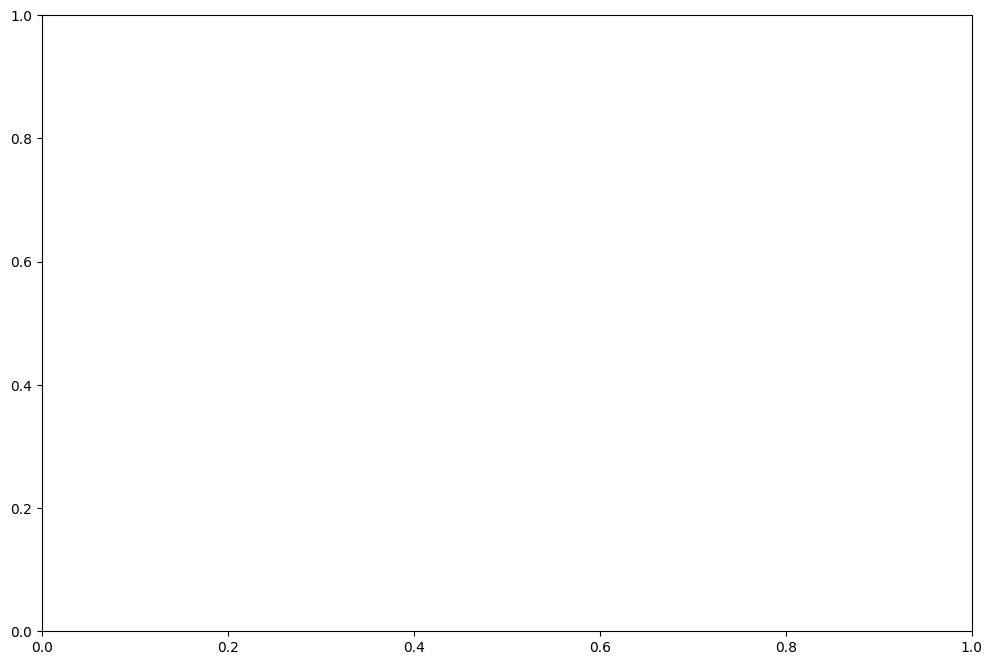

In [59]:
# # Create scatter plot
# plt.figure(figsize=(12, 8))
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_cls, cmap='tab20', alpha=0.6)
# plt.colorbar()
# plt.title('t-SNE visualization of HDBSCAN clusters')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.show()